In [1249]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa
import numpy as np
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")
import gurobipy as gp
from gurobipy import GRB
import cartopy.crs as ccrs
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [1250]:
"load electricity demand data";
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime

"Load the heat demand data";
df_heat = pd.read_csv('data/heat_demand.csv', sep=';', index_col=0) # in MWh
df_heat.index = pd.to_datetime(df_heat.index) #change index to datatime


"Onshore Wind";
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
"Offshore Wind";
df_offshore = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshore.index = pd.to_datetime(df_offshore.index)
"Solar Data";
df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)


In [1251]:
import os
os.getcwd()

'c:\\Users\\Pulin\\Desktop\\integrated-energy-grids\\integrated-energy-grids'

https://meteostat.net/en/place/gb/london?s=03779&t=2024-01-01/2024-12-31

In [2187]:
Temp_GBR = pd.read_csv("data/london temperature data.csv")
Temp_DNK = pd.read_csv("data/denmark 1 temperature data.csv")
Temp_NDL = pd.read_csv("data/Amsterdam temperature data.csv")

In [2188]:
# Define a function to replace temperature values outside [-5, 37] with the previous valid value
def replace_extreme_temperatures(df, column_name, min_val=-5, max_val=37):
    for i in range(1, len(df)):
        if df.at[i, column_name] < min_val or df.at[i, column_name] > max_val:
            df.at[i, column_name] = df.at[i-1, column_name]
    return df

# Apply to each dataset
Temp_GBR = replace_extreme_temperatures(Temp_GBR, 'TMP')
Temp_DNK = replace_extreme_temperatures(Temp_DNK, 'TMP')
Temp_NDL = replace_extreme_temperatures(Temp_NDL, 'TMP')


<Axes: >

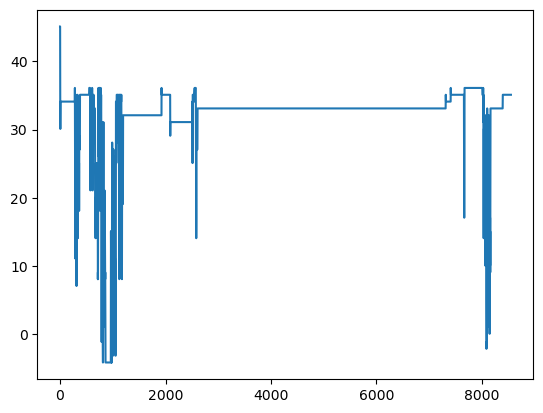

In [2189]:
Temp_GBR["TMP"].plot()

In [2190]:
Temp_DNK["TMP"]

0       40.1
1       30.1
2       30.1
3       30.1
4       30.1
        ... 
2835     0.1
2836     0.1
2837     0.1
2838     0.1
2839     0.1
Name: TMP, Length: 2840, dtype: float64

In [2191]:

Temp_GBR["TMP"][0:3000].mean()
Temp_NDL["TMP"][0:3000].mean()
Temp_DNK["TMP"][0:3000].mean()

23.473239436619718

In [2192]:
cop(Temp_NDL["TMP"][0:3000].mean(), t_sink=55)

3.951780539767467

<Axes: xlabel='utc_time'>

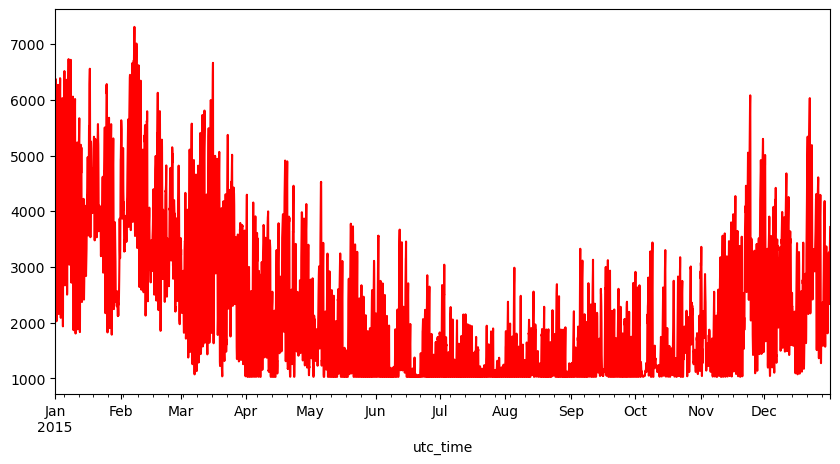

In [2193]:
plt.figure(figsize=(10, 5))
#df_heat["GBR"].plot(color ="blue")
#df_heat["NLD"].plot(color = "orange")
df_heat["PRT"].plot(color = "red")

<Axes: xlabel='utc_time'>

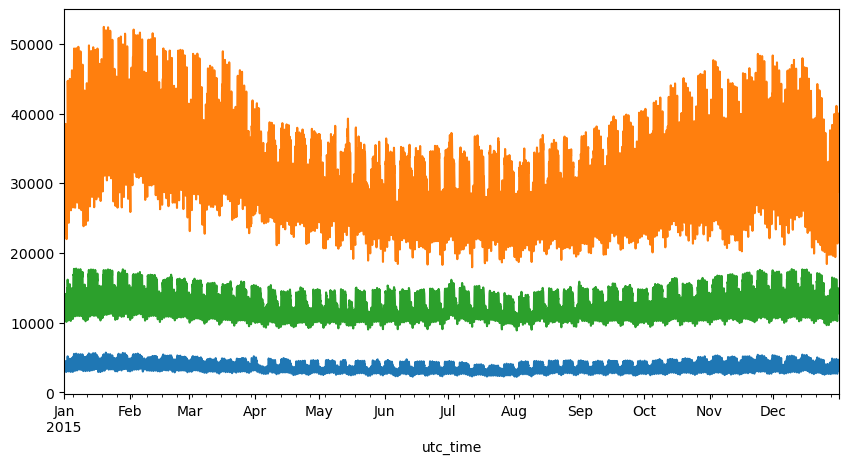

In [2194]:
plt.figure(figsize=(10, 5))
df_elec["DNK"].plot()
df_elec["GBR"].plot()
df_elec["NLD"].plot()

In [2197]:


year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])


In [2198]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

In [2199]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

In [2200]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [2201]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [2202]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

In [2203]:
def cop(t_source, t_sink=55):
    delta_t = t_sink - t_source
    return 6.81 - 0.121 * delta_t + 0.00063 * delta_t**2

In [2204]:
costs.at["central air-sourced heat pump", "capital_cost"]

111082358.72659878

In [2205]:
"Time Period in which our model is running";

hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

In [2206]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

### Start of MODEL

In [2481]:
n = pypsa.Network()
n.set_snapshots(hours_in_2015)

n.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
n.add("Carrier", "onshorewind")
n.add("Carrier", "offshorewind")
n.add("Carrier", "nuclear")
n.add("Carrier","solar")
n.add("Carrier","heat")
n.add("Carrier","heat pump")

# CAPEX values for different technologies (in €/MW)
offshoreWind_capex = 2.8e6
onshoreWind_capex = 1.4e6
solar_capex = 628e3
ccgt_capex = 1.04e6
nuclear_capex = 11.08e6
electrolyzer_capex = 350e3
h2_tank_capex = 8.4e3
fuel_cell_capex = 339e3

if you want to run just for the UK reomve the DNK and NLD from the nodes variable and don´t run the code(block) for the interconnections between the 3 countires.

- also the global CO2 constraint is commented out (optinal)

In [2483]:
nodes = pd.Series( ['GBR','DNK','NLD']).values
neighbors =pd.Series(['DNK','NLD']).values
c = list(set(nodes) - set(neighbors))[0]

# longitude
xs = {'GBR':-2.1698,
    'NLD':6.04248,
     "DNK":9.732249,
     }

# latitude
ys = {'GBR':53.243852,
      'NLD':52.709675,
     'DNK':55.990430,
     }

# this is in MW
Nuclear_Cap = {'GBR':10000,
      'NLD':500,
     'DNK':0,
     }

Windoff_Cap = {'GBR':16000,
      'NLD':int(11714*0.405),
     'DNK':2700,
     }

Windon_Cap = {'GBR':14000,
      'NLD':int(11714*0.595),
     'DNK':3800,
     }


Solar_Cap = {'GBR':17200,
      'NLD':23000,
     'DNK':4000,
     }


COP_avg = {'GBR':cop(Temp_GBR["TMP"].mean(), t_sink=55),
      'NLD':cop(Temp_NDL["TMP"].mean(), t_sink=55),
     'DNK':cop(Temp_DNK["TMP"].mean(), t_sink=55),
     }

In [2484]:
COP_avg

{'GBR': 4.343670984789758, 'NLD': 4.088338080648216, 'DNK': 3.621442049752033}

In [2485]:
n.madd("Bus",
       names=["electrical bus " + n for n in nodes],
       x=[xs[n] for n in nodes],
       y=[ys[n] for n in nodes],
       location=nodes,
       carrier="electricity")


Index(['electrical bus GBR', 'electrical bus DNK', 'electrical bus NLD'], dtype='object')

In [2486]:
"Heat Bus";
n.madd("Bus",
       names=["heat bus " + n for n in nodes],
       x=[xs[n] for n in nodes],
       y=[ys[n] for n in nodes],
       location=nodes,
       )

"Gas Bus";
n.madd("Bus", names = ["gas bus " + n for n in nodes],
       x=[xs[n] for n in nodes],
       y=[ys[n] for n in nodes],
       location =nodes,
       )

"Gas Storage for CHP is local for each country";
n.madd("Store", names = ["gas storage " + n for n in nodes], e_initial = 1e7, e_nom = 1e7,
       bus = ["gas bus " + n for n in nodes],
       x=[xs[n] for n in nodes],
       y=[ys[n] for n in nodes],
       location = nodes)


"Adding CHP";
n.madd("Link", names = ["CHP " + n for n in nodes],
       bus0 = "gas bus " + nodes,
       bus1 = "electrical bus " + nodes,
       bus2 = "heat bus " + nodes,
       p_nom_extendable = True,
       marginal_cost = 80,
       efficiency = 0.4,
       efficiency2 = 0.4,
)  

"Heat Pump";
n.madd(
    "Link",
    names=["heat pump " + n for n in nodes],  # Heat pump names
    carrier="heat pump",
    bus0=["electrical bus " + n for n in nodes],  # Electricity buses
    bus1=["heat bus " + n for n in nodes],  # Heat buses
    p_nom_extendable=True,
    p_min_pu=-1,  # Minimum partial load
    efficiency=[COP_avg[n] for n in nodes],  # Coefficient of Performance (COP)
    capital_cost= costs.at["central air-sourced heat pump", "capital_cost"],  # Capital cost(€/MWe/a)
)


"Heat Loads";
n.madd("Load",
       names = ["heat load " + n for n in nodes],
       bus= "heat bus " + nodes,
       p_set=df_heat[nodes].values)

Index(['heat load GBR', 'heat load DNK', 'heat load NLD'], dtype='object', name='Load')

In [2487]:
costs.at["central air-sourced heat pump", "capital_cost"]

111082358.72659878

In [2488]:
n.consistency_check()

In [2489]:
CF_wind_on = pd.DataFrame()
CF_wind_off = pd.DataFrame()
CF_solar = pd.DataFrame()
for i in range(len(nodes)):
    CF_wind_on[nodes[i]] = df_onshorewind[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    CF_wind_off[nodes[i]] = df_offshore[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    CF_solar[nodes[i]] = df_solar[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]

In [2490]:
annuity(25,0.07)*onshoreWind_capex*(1+0.03)

123738.7658321998

In [2491]:
capital_cost_onshorewind = annuity(25,0.07)*onshoreWind_capex*(1+0.03) # in €/MW
n.madd("Generator",
        [n + " onshorewind" for n in nodes],
        bus="electrical bus " + nodes,
        p_nom_extendable=True,
        carrier="onshorewind",
        p_nom_max = [Windon_Cap[n] for n in nodes],
        #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
        capital_cost = capital_cost_onshorewind,
        marginal_cost = 0,
        p_max_pu = CF_wind_on[nodes].values)

capital_cost_offshorewind = annuity(25,0.07)*offshoreWind_capex*(1+0.03) # in €/MW
n.madd("Generator",
            [n + " offshorewind" for n in nodes],
            bus="electrical bus " + nodes,
            p_nom_extendable=True,
            carrier="offshorewind",
            p_nom_max = [Windoff_Cap[n] for n in nodes],
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_off[nodes].values)

"CCGT (Combine Cycle Gas Turbine) generator";
capital_cost_CCGT = annuity(30,0.07)*(ccgt_capex + 14.32 * 1000) # in €/MW
fuel_cost = 30.32 # in €/MWh_th
efficiency = 0.5 # MWh_elec/MWh_th
marginal_cost_CCGT = fuel_cost/efficiency # in €/MWh_el
n.madd("Generator",
            [n + " CCGT" for n in nodes],
            bus="electrical bus " + nodes,
            p_nom_extendable=True,
            carrier="gas",
            capital_cost = capital_cost_CCGT,
            marginal_cost = marginal_cost_CCGT)
"Solar";
capital_cost_solar = annuity(25,0.07)*solar_capex*(1+0.03) # in €/MW
n.madd("Generator",
                  [n + " solar" for n in nodes],
                  bus= "electrical bus " + nodes,
                  p_nom_extendable=True,
                  carrier="solar",
                  p_nom_max = [Solar_Cap[n] for n in nodes],
                  #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                  capital_cost = capital_cost_solar,
                  marginal_cost = 0,
                  p_max_pu = CF_solar.values)

"Nuclear";
capital_cost_nuclear = annuity(30,0.07)*(nuclear_capex + 14.45 * 1000) # in €/MW
fuel_cost = 6.2 # in €/MWh_th
efficiency = 0.33 # MWh_elec/MWh_th
marginal_cost_nuclear = fuel_cost/efficiency # in €/MWh_el

n.madd("Generator",
                  [n + " nuclear" for n in nodes],
                  bus = "electrical bus " + nodes,
                  p_nom_extendable=True,
                  carrier="nuclear",
                  p_nom_max = [Nuclear_Cap[n] for n in nodes],
                  capital_cost = capital_cost_nuclear,
                  marginal_cost = marginal_cost_nuclear)

Index(['GBR nuclear', 'DNK nuclear', 'NLD nuclear'], dtype='object')

In [2492]:
"Electrical Loads";
n.madd(
    "Load",
    names=["electric load " + n for n in nodes],  # Unique names for electrical loads
    bus="electrical bus " + nodes,  # Assign to the corresponding electricity buses
    p_set=df_elec[nodes].values # Electricity demand values
  ) 

Index(['electric load GBR', 'electric load DNK', 'electric load NLD'], dtype='object', name='Load')

In [2493]:
n.consistency_check()

In [2494]:
costs.at["central air-sourced heat pump", "capital_cost"]

111082358.72659878

In [2495]:

"Manually Adding the eletrical interconnections between the countries";

CAPEX_HVDC_subsea = 1950 # in EUR/MW/km

# Orgionally was using 400

n.add("Link",
     "GBR - DNK",
     bus0="electrical bus GBR",
     bus1= "electrical bus DNK",
     p_nom_extendable=False, # capacity is optimised
     p_nom = 1400, # MW
     p_min_pu=-1,
     length=800, # length (in km) between country a and country b
     capital_cost=CAPEX_HVDC_subsea*800*annuity(30,0.07)) # capital cost [EUR/MW/km] * length [km] = [EUR/MW]


In [2496]:

n.add("Link",
     "GBR - NLD",
     bus0="electrical bus GBR",
     bus1= "electrical bus NLD",
     p_nom_extendable=False, # capacity is optimised
     p_nom = 2000, # MW
     p_min_pu=-1,
     length=200, # length (in km) between country a and country b
     capital_cost=CAPEX_HVDC_subsea*200*annuity(30,0.07)) # capital cost [EUR/MW/km] * length [km] = [EUR/MW]


In [2497]:

n.add("Link",
      "DNK - NLD",
      bus0="electrical bus DNK", 
      bus1 = "electrical bus NLD",
      p_nom_extendable=False, # capacity is optimised
      p_nom = 700, # MW
      p_min_pu=-1,
     length=325, # length (in km)
     capital_cost=CAPEX_HVDC_subsea*325*annuity(30,0.07)) # capital cost [EUR/MW/km] * length [km] = [EUR/MW]

In [2498]:
print(n.links)

                             bus0                bus1          bus2  \
Link                                                                  
CHP GBR               gas bus GBR  electrical bus GBR  heat bus GBR   
CHP DNK               gas bus DNK  electrical bus DNK  heat bus DNK   
CHP NLD               gas bus NLD  electrical bus NLD  heat bus NLD   
heat pump GBR  electrical bus GBR        heat bus GBR                 
heat pump DNK  electrical bus DNK        heat bus DNK                 
heat pump NLD  electrical bus NLD        heat bus NLD                 
GBR - DNK      electrical bus GBR  electrical bus DNK                 
GBR - NLD      electrical bus GBR  electrical bus NLD                 
DNK - NLD      electrical bus DNK  electrical bus NLD                 

               p_nom_extendable  marginal_cost  efficiency  efficiency2 type  \
Link                                                                           
CHP GBR                    True           80.0    0.400000

In [2499]:
n.consistency_check()

In [2500]:
n.statistics()

Capacity Factor  Capital Expenditure  Curtailment  \
          carrier                                                           
Generator gas                       NaN                  0.0          0.0   
          nuclear                   NaN                  0.0          0.0   
          offshorewind              NaN                  0.0          0.0   
          onshorewind               NaN                  0.0          0.0   
          solar                     NaN                  0.0          0.0   
Link      AC                        NaN                  0.0          NaN   
          electricity               NaN                  0.0          NaN   
          heat pump                 NaN                  0.0          NaN   
Load      -                         NaN                  NaN          NaN   
Store     AC                        NaN                  0.0          NaN   

                        Dispatch  Installed Capacity  Market Value  \
          carrier                                                    
Generator gas                0.0                 0.0           NaN   
          nuclear            0.0                 0.0           NaN   
          offshorewind       0.0                 0.0           NaN   
          onshorewind        0.0                 0.0           NaN   
          solar              0.0                 0.0           NaN   
Link      AC                 NaN                 0.0           NaN   
          electricity        NaN              4100.0           NaN   
          heat pump          NaN                 0.0           NaN   
Load      -                  0.0                 NaN           NaN   
Store     AC                 0.0          30000000.0           NaN   

                        Operational Expenditure  Optimal Capacity  Revenue  \
          carrier                                                            
Generator gas                               0.0               0.0      0.0   
          nuclear                           0.0               0.0      0.0   
          offshorewind                      0.0               0.0      0.0   
          onshorewind                       0.0               0.0      0.0   
          solar                             0.0               0.0      0.0   
Link      AC                                0.0               0.0      0.0   
          electricity                       0.0               0.0      0.0   
          heat pump                         0.0               0.0      0.0   
Load      -                                 NaN               NaN      0.0   
Store     AC                                0.0               0.0      0.0   

                        Supply  Withdrawal  
          carrier                           
Generator gas              0.0         0.0  
          nuclear          0.0         0.0  
          offshorewind     0.0         0.0  
          onshorewind      0.0         0.0  
          solar            0.0         0.0  
Link      AC               NaN         NaN  
          electricity      NaN         NaN  
          heat pump        NaN         NaN  
Load      -                0.0         0.0  
Store     AC               0.0         0.0

In [2501]:
n.links

,bus0,bus1,bus2,p_nom_extendable,marginal_cost,efficiency,efficiency2,type,carrier,build_year,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
CHP GBR,gas bus GBR,electrical bus GBR,heat bus GBR,True,80.0,0.400000,0.4,,AC,0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
CHP DNK,gas bus DNK,electrical bus DNK,heat bus DNK,True,80.0,0.400000,0.4,,AC,0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
CHP NLD,gas bus NLD,electrical bus NLD,heat bus NLD,True,80.0,0.400000,0.4,,AC,0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
heat pump GBR,electrical bus GBR,heat bus GBR,,True,0.0,4.343671,1.0,,heat pump,0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
heat pump DNK,electrical bus DNK,heat bus DNK,,True,0.0,3.621442,1.0,,heat pump,0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
heat pump NLD,electrical bus NLD,heat bus NLD,,True,0.0,4.088338,1.0,,heat pump,0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
GBR - DNK,electrical bus GBR,electrical bus DNK,,False,0.0,1.000000,1.0,,electricity,0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
GBR - NLD,electrical bus GBR,electrical bus NLD,,False,0.0,1.000000,1.0,,electricity,0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
DNK - NLD,electrical bus DNK,electrical bus NLD,,False,0.0,1.000000,1.0,,electricity,0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


"CO_2 emmission Data

https://ourworldindata.org/co2/country/united-kingdom?country=GBR~DNK~NLD


In [2503]:
n.lopf(n.snapshots,
             pyomo=False,
             solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.73s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Pulin\AppData\Local\Temp\pypsa-problem-8mzb30rq.lp
Reading time = 1.57 seconds
obj: 578161 rows, 262822 columns, 1117027 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 578161 rows, 262822 columns and 1117027 nonzeros
Model fingerprint: 0xce42ec66
Coefficient statistics:
  Matrix range     [1e-03, 4e+00]
  Objective range  [1e+00, 1e+08]
  Bounds range     [5e+02, 2e+04]
  RHS range        [7e+02, 6e+07]
Presolve removed 404759 rows and 100615 columns
Presolve time: 0.95s
Presolved: 173402 rows, 162207 columns, 535266 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.07s

Barrier statistics:
 Dense cols : 17
 AA' NZ     : 4.481e+05
 Factor 

INFO:pypsa.linopf:Optimization successful. Objective value: 3.50e+12


('ok', 'optimal')

In [2504]:
"Marginal Price of Energy";
n.buses_t.marginal_price.mean() # EUR/MWh

Bus
electrical bus GBR      120.845442
electrical bus DNK      119.422389
electrical bus NLD      118.196881
heat bus GBR           2947.156909
heat bus DNK           3534.519384
heat bus NLD           3130.570769
gas bus GBR           18470.650450
gas bus DNK            5028.521228
gas bus NLD           10391.247042
dtype: float64

In [2505]:
"Minimum cost of the system";
n.objective/1e9 # Bn of EUR per annum

3503.621262765117

In [2507]:
"Optimal Generator Capacity (GW)";
n.generators.p_nom_opt/1e3 # in GW

Generator
GBR onshorewind     14.000000
DNK onshorewind      3.800000
NLD onshorewind      6.969000
GBR offshorewind    16.000000
DNK offshorewind     2.700000
NLD offshorewind     4.744000
GBR CCGT            58.120087
DNK CCGT             4.696667
NLD CCGT            22.562253
GBR solar           17.200000
DNK solar            4.000000
NLD solar           23.000000
GBR nuclear          8.603513
DNK nuclear          0.000000
NLD nuclear          0.000000
Name: p_nom_opt, dtype: float64

In [2508]:
n.links.p_nom_opt.div(1e3)

Link
CHP GBR          60.638886
CHP DNK          14.322521
CHP NLD          30.855538
heat pump GBR    21.553428
heat pump DNK     2.409544
heat pump NLD     7.134597
GBR - DNK         1.400000
GBR - NLD         2.000000
DNK - NLD         0.700000
Name: p_nom_opt, dtype: float64

In [ ]:
"Energy Generation (TWh) per year";
n.generators_t.p.sum().div(1e6)  # MWh -> TWh

Generator
GBR onshorewind      31.895374
DNK onshorewind       9.743789
NLD onshorewind      14.619582
GBR offshorewind     48.781248
DNK offshorewind     10.773833
NLD offshorewind     15.355358
GBR CCGT            233.717237
DNK CCGT             13.603900
NLD CCGT             68.468336
GBR solar            15.555183
DNK solar             3.765614
NLD solar            23.383210
GBR nuclear          75.268702
DNK nuclear           0.000000
NLD nuclear           0.000000
dtype: float64

In [2510]:
"Energy Flow Between links";
n.links.p_nom_opt # in MW

Link
CHP GBR          60638.886275
CHP DNK          14322.521331
CHP NLD          30855.538207
heat pump GBR    21553.428342
heat pump DNK     2409.543914
heat pump NLD     7134.597036
GBR - DNK         1400.000000
GBR - NLD         2000.000000
DNK - NLD          700.000000
Name: p_nom_opt, dtype: float64

In [2511]:
# Get CO2 intensity for each carrier
co2_intensity = n.carriers["co2_emissions"]

# Match generators with their carriers
generator_carriers = n.generators["carrier"]

# Calculate emissions for each generator
emissions = n.generators_t.p.multiply(generator_carriers.map(co2_intensity), axis=1)

# Sum emissions over all generators and time steps
total_emissions = emissions.sum().sum()  # in tons of CO2

print(f"Total CO2 Emissions: {total_emissions/1e6:.2f} Mtons")

Total CO2 Emissions: 60.00 Mtons


In [2512]:
"Carbon Prices";

print(n.global_constraints.constant) # CO2 limit (constant in the constraint)

print(n.global_constraints.mu) # CO2 price (Lagrance multiplier in the constraint)

GlobalConstraint
co2_limit    60000000.0
Name: constant, dtype: float64
GlobalConstraint
co2_limit    267.34853
Name: mu, dtype: float64


In [2513]:
n.stores.e_nom_opt

Store
gas storage GBR    10000000.0
gas storage DNK    10000000.0
gas storage NLD    10000000.0
Name: e_nom_opt, dtype: float64

In [2514]:
n.consistency_check()

<Axes: xlabel='snapshot', ylabel='MW'>

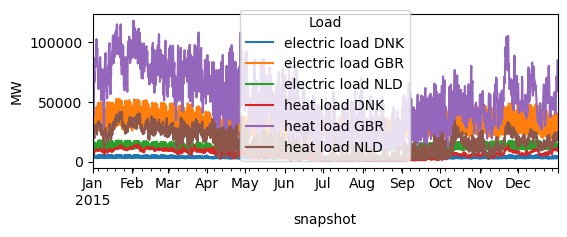

In [2515]:
n.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

In [2516]:
n.generators.assign(g=n.generators_t.p.sum()).groupby(["bus","carrier"]).g.sum()

bus                 carrier     
electrical bus DNK  gas             1.360390e+07
                    nuclear         0.000000e+00
                    offshorewind    1.077383e+07
                    onshorewind     9.743789e+06
                    solar           3.765614e+06
electrical bus GBR  gas             2.337172e+08
                    nuclear         7.526870e+07
                    offshorewind    4.878125e+07
                    onshorewind     3.189537e+07
                    solar           1.555518e+07
electrical bus NLD  gas             6.846834e+07
                    nuclear         0.000000e+00
                    offshorewind    1.535536e+07
                    onshorewind     1.461958e+07
                    solar           2.338321e+07
Name: g, dtype: float64

<Axes: xlabel='snapshot', ylabel='CF'>

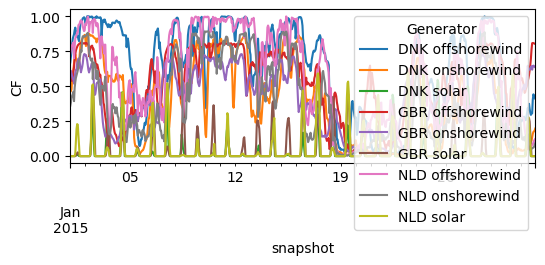

In [2517]:
n.generators_t.p_max_pu.loc["2015-01"].plot(figsize=(6, 2), ylabel="CF")

In [2518]:
# Check the optimized capacity of CHP links
chp_capacity = n.links.loc[n.links.index.str.contains("CHP"), "p_nom_opt"]
print("CHP Capacities (MW):")
print(chp_capacity)

# Check the optimized capacity of boiler links
boiler_capacity = n.links.loc[n.links.index.str.contains("heat pump"), "p_nom_opt"]
print("heat pump (MW):")
print(boiler_capacity)

CHP Capacities (MW):
Link
CHP GBR    60638.886275
CHP DNK    14322.521331
CHP NLD    30855.538207
Name: p_nom_opt, dtype: float64
heat pump (MW):
Link
heat pump GBR    21553.428342
heat pump DNK     2409.543914
heat pump NLD     7134.597036
Name: p_nom_opt, dtype: float64


In [2519]:
n.links.p_nom_opt/1e3 # in GW

Link
CHP GBR          60.638886
CHP DNK          14.322521
CHP NLD          30.855538
heat pump GBR    21.553428
heat pump DNK     2.409544
heat pump NLD     7.134597
GBR - DNK         1.400000
GBR - NLD         2.000000
DNK - NLD         0.700000
Name: p_nom_opt, dtype: float64

In [2520]:
n.generators_t.p.sum().div(1e6) 

Generator
GBR onshorewind      31.895374
DNK onshorewind       9.743789
NLD onshorewind      14.619582
GBR offshorewind     48.781248
DNK offshorewind     10.773833
NLD offshorewind     15.355358
GBR CCGT            233.717237
DNK CCGT             13.603900
NLD CCGT             68.468336
GBR solar            15.555183
DNK solar             3.765614
NLD solar            23.383210
GBR nuclear          75.268702
DNK nuclear           0.000000
NLD nuclear           0.000000
dtype: float64

<Axes: xlabel='snapshot', ylabel='MWh'>

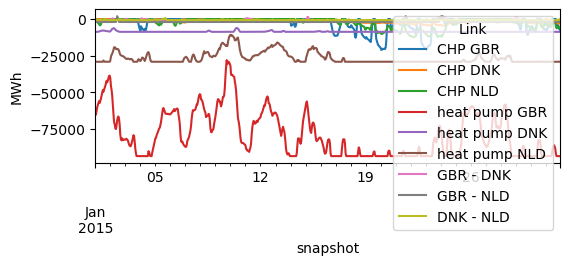

In [2521]:
"Electrical Dispatch CHP and Heat Dispatch Heat Pump";
n.links_t.p1.loc["2015-01"].plot(figsize=(6, 2), ylabel="MWh")

- add electricty generation to the CHP

Text(0.5, 1.0, 'Electrical Generation from CHP')

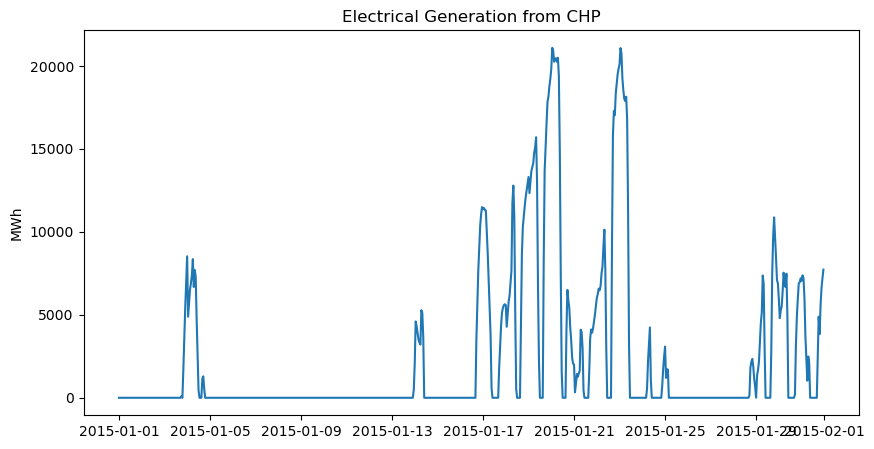

In [ ]:
"Electrcity Generation CHP";

CHP_el_GBR = -n.links_t.p1.loc["2015-01"]["CHP GBR"] # MWh
#CHP_el_DNK = -n.links_t.p1.loc["2015-01"]["CHP DNK"] # MWh
#CHP_el_NLD = -n.links_t.p1.loc["2015-01"]["CHP NLD"] # MWh

plt.figure(figsize=(10, 5))
plt.plot(CHP_el_GBR, label = "CHP GBR")
#plt.plot(CHP_el_DNK, label = "CHP DNK") 
#plt.plot(CHP_el_NLD, label = "CHP NLD")
plt.ylabel("MWh")
plt.title("Electrical Generation from CHP")

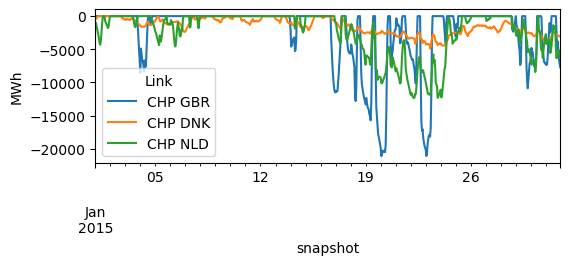

In [2523]:
"Heat Dispatch from CHP";
n.links_t.p2.loc["2015-01"].plot(figsize=(6, 2), ylabel="MWh")

CHP_heat_GBR = -n.links_t.p2.loc["2015-01"]["CHP GBR"] # MWh
#CHP_heat_DNK = -n.links_t.p2.loc["2015-01"]["CHP DNK"] # MWh
#CHP_heat_NLD = -n.links_t.p2.loc["2015-01"]["CHP NLD"] # MWh

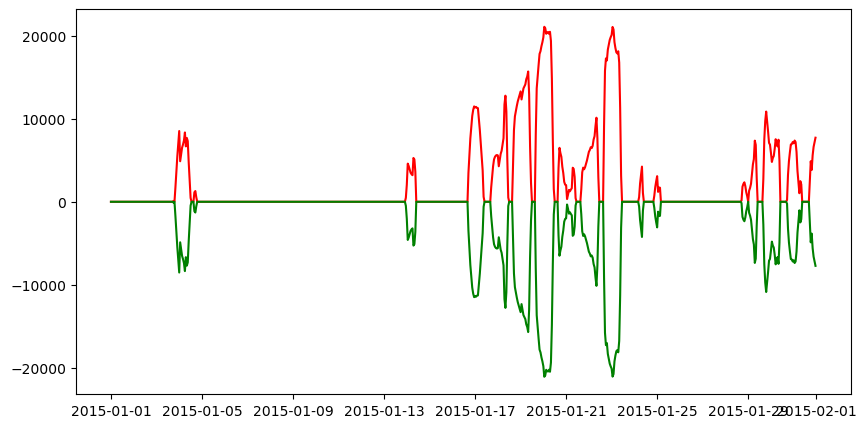

In [2524]:
plt.figure(figsize=(10, 5))
plt.plot(CHP_heat_GBR, color = "red", label = "Heat Output HeatPump")
plt.plot(-CHP_el_GBR,color = "green", label = "Electricty Input Heat Pump")

In [2526]:
"Heat Dispatch for Heat Pump";

heatpump_heat_GBR = -n.links_t.p1.loc["2015-01"]["heat pump GBR"] # MWh
heatpump_heat_DNK = -n.links_t.p1.loc["2015-01"]["heat pump DNK"] # MWh
heatpump_heat_NLD = -n.links_t.p1.loc["2015-01"]["heat pump NLD"] # MWh

<Axes: xlabel='snapshot', ylabel='dispatch'>

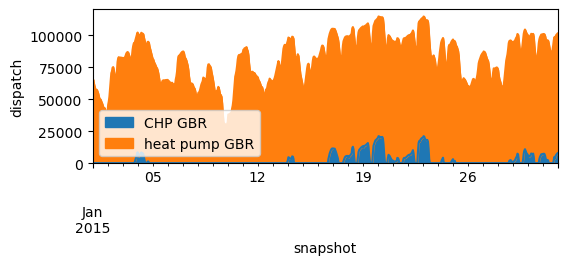

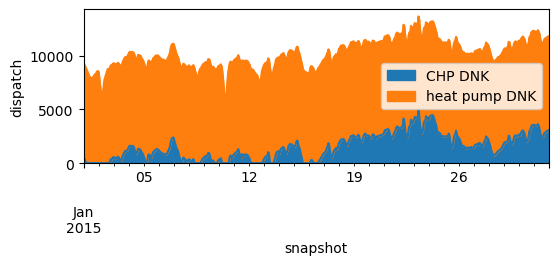

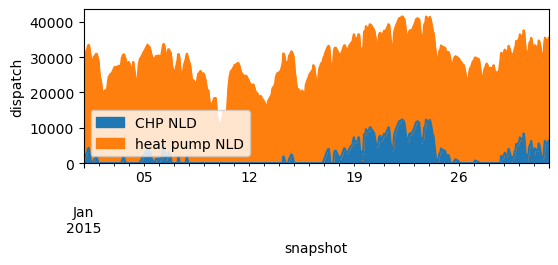

In [2527]:
"Heat Dispatch for each country";
pd.concat([CHP_heat_GBR ,heatpump_heat_GBR],axis = 1).plot.area(figsize=(6, 2), ylabel="dispatch")
pd.concat([CHP_heat_DNK ,heatpump_heat_DNK],axis = 1).plot.area(figsize=(6, 2), ylabel="dispatch")
pd.concat([CHP_heat_NLD ,heatpump_heat_NLD],axis = 1).plot.area(figsize=(6, 2), ylabel="dispatch")

In [2528]:
pd.concat([CHP_heat_GBR ,heatpump_heat_GBR],axis = 1).sum()

CHP GBR          1.748455e+06
heat pump GBR    5.883210e+07
dtype: float64

<Axes: title={'center': 'Heat'}>

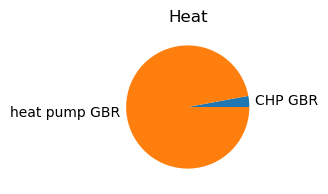

In [2529]:
pd.concat([CHP_heat_GBR ,heatpump_heat_GBR],axis = 1).sum().plot.pie(figsize=(6, 2), title='Heat')

<Axes: title={'center': 'Heat'}>

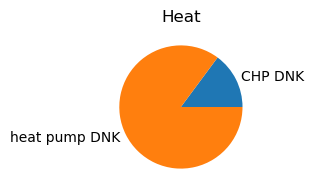

In [2530]:
pd.concat([CHP_heat_DNK ,heatpump_heat_DNK],axis = 1).sum().plot.pie(figsize=(6, 2), title='Heat')

<Axes: title={'center': 'Heat'}>

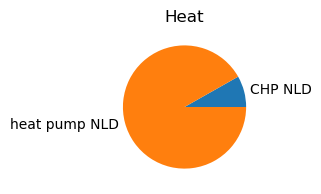

In [2531]:
pd.concat([CHP_heat_NLD ,heatpump_heat_NLD],axis = 1).sum().plot.pie(figsize=(6, 2), title='Heat')

In [2532]:
gen = n.generators.assign(g=n.generators_t.p.sum()).groupby(["bus","carrier"]).g.sum();

In [2533]:
import matplotlib.patches as mpatches

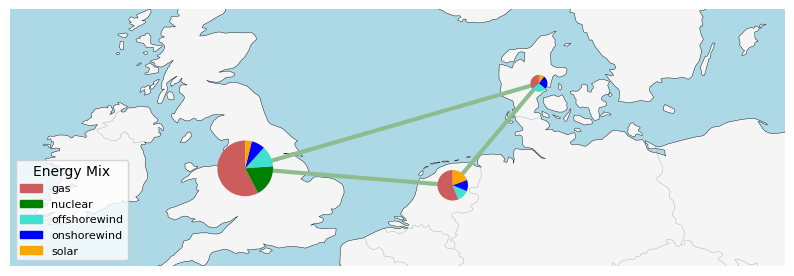

In [2534]:
energy_colors = {
    "gas": "indianred",
    "nuclear": "green",
    "offshorewind": "turquoise",
    "onshorewind": "blue",
    "solar": "orange",
}

# Create legend patches
legend_patches = [
    mpatches.Patch(color=color, label=carrier) for carrier, color in energy_colors.items()
]

# Plot the network
fig, ax = plt.subplots(
    1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(10,10)
)
n.plot(
    bus_sizes=gen / 4e8,
    bus_colors=energy_colors,
    ax=ax,
    color_geomap=True,
    link_widths=3,
    margin=0.76,
)

# Add the legend manually
plt.legend(
    handles=legend_patches,
    loc="lower left",  # Adjust location as needed
    title="Energy Mix",
    fontsize=8,
    title_fontsize=10,
)

<Axes: title={'center': 'Generation Mix by Carrier'}, xlabel='bus'>

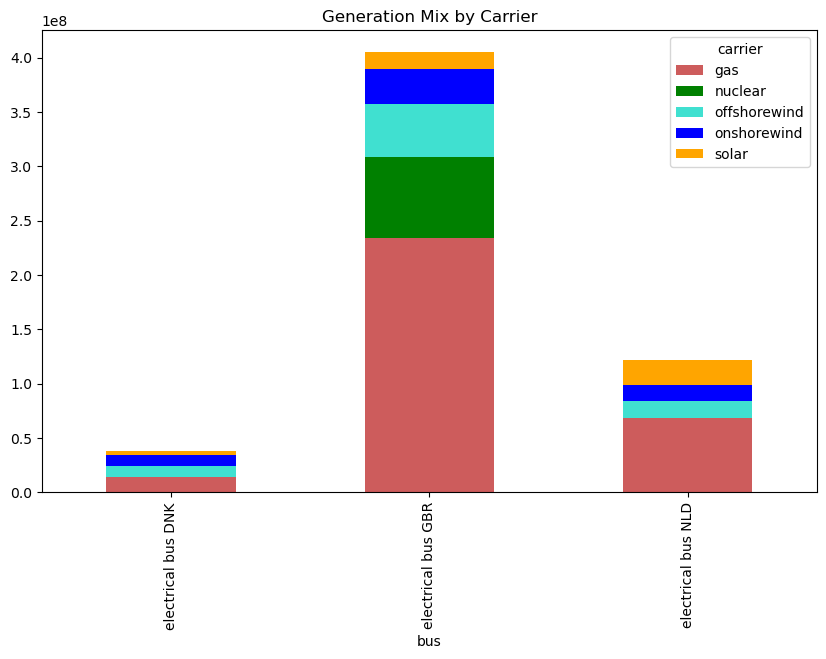

In [2535]:
gen.unstack(level='carrier').fillna(0).plot(kind='bar', stacked=True, figsize=(10, 6),color=energy_colors.values(), title="Generation Mix by Carrier")

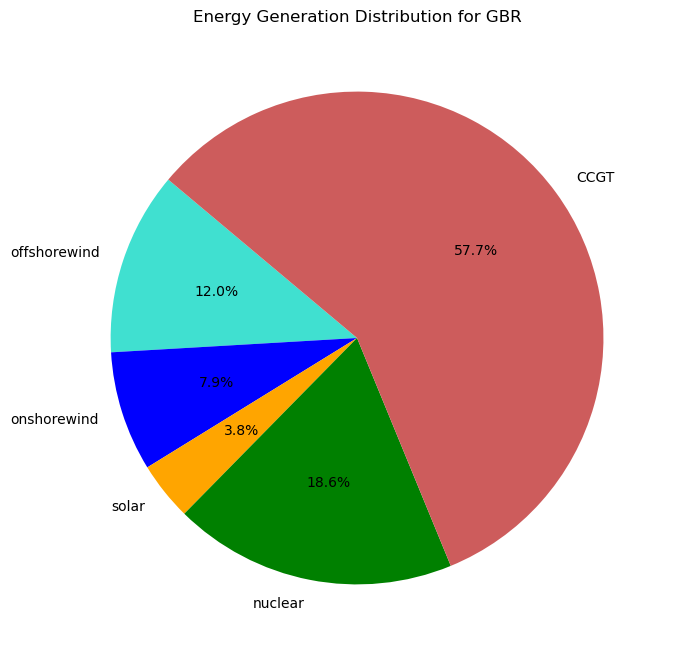

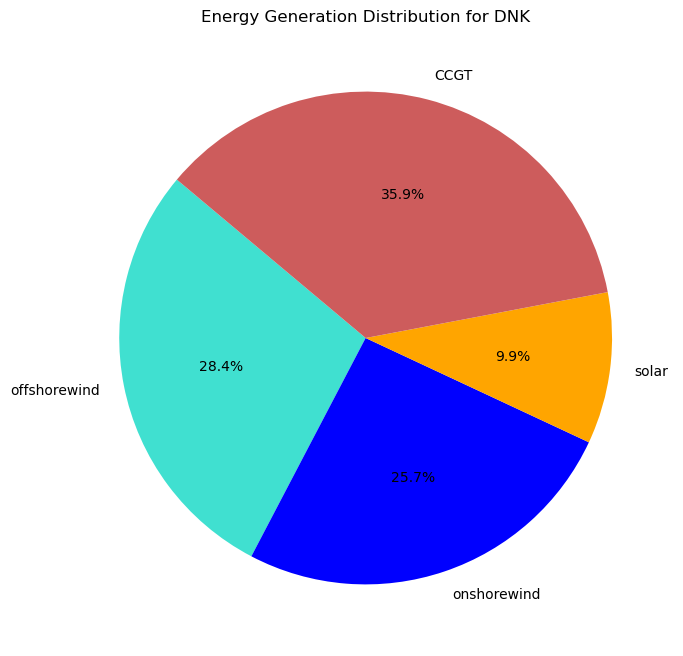

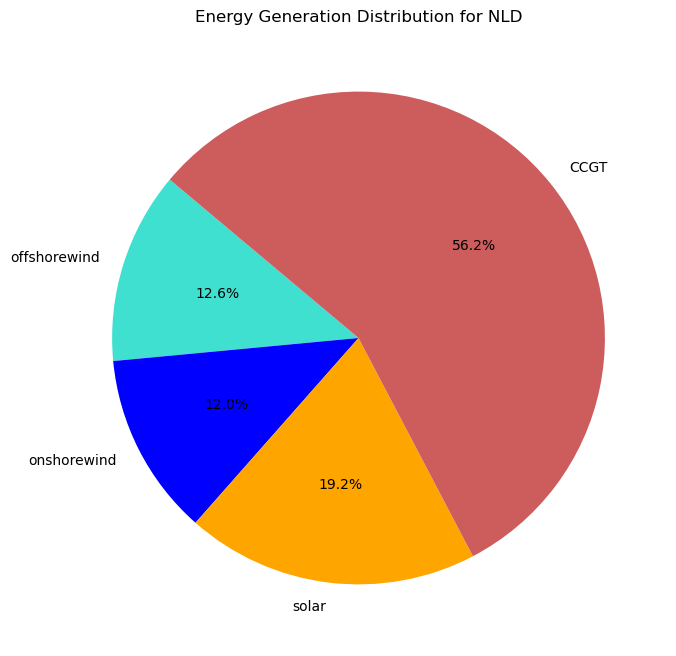

In [2536]:
import matplotlib.pyplot as plt

# List of countries
countries = ['GBR', 'DNK', 'NLD']

# List of energy sources
energy_sources = ['offshorewind', 'onshorewind', 'solar', 'nuclear', 'CCGT']

# Colors for the pie chart
colors = ['turquoise','blue', 'orange', 'green', 'indianred']

# Loop through each country
for country in countries:
    # Calculate the generation sums for each energy source
    sizes = [n.generators_t.p[f"{country} {source}"].sum() for source in energy_sources]
    
    # Filter out sources with approximately zero contribution
    filtered_sizes = [size for size in sizes if size > 0]
    filtered_labels = [energy_sources[i] for i in range(len(sizes)) if sizes[i] > 0]
    filtered_colors = [colors[i] for i in range(len(sizes)) if sizes[i] > 0]
    
    # Create the pie chart
    if filtered_sizes:  # Only plot if there are non-zero contributions
        plt.figure(figsize=(8, 8))
        plt.pie(filtered_sizes, labels=filtered_labels, autopct='%1.1f%%', startangle=140, colors=filtered_colors)
        plt.title(f'Energy Generation Distribution for {country}')
        plt.show()

In [2537]:
n.links_t.p1

Link,CHP GBR,CHP DNK,CHP NLD,heat pump GBR,heat pump DNK,heat pump NLD,GBR - DNK,GBR - NLD,DNK - NLD
snapshot,,,,,,,,,
2015-01-01 00:00:00+00:00,-0.0,-367.004762,-1040.125466,-64062.547653,-8726.023653,-29168.644752,-1400.0,-2000.0,-700.000000
2015-01-01 01:00:00+00:00,-0.0,-436.083041,-1009.839418,-65383.396920,-8726.023653,-29168.644752,-1400.0,-2000.0,-700.000000
2015-01-01 02:00:00+00:00,-0.0,-315.247847,-1488.157077,-62689.532240,-8726.023653,-29168.644752,-1400.0,-2000.0,-199.113933
2015-01-01 03:00:00+00:00,-0.0,-203.395919,-2052.551052,-60457.750621,-8726.023653,-29168.644752,-1400.0,-2000.0,-516.262005
2015-01-01 04:00:00+00:00,-0.0,-58.352535,-2513.880699,-58777.369565,-8726.023653,-29168.644752,-1400.0,-2000.0,-628.668621
...,...,...,...,...,...,...,...,...,...
2015-12-31 19:00:00+00:00,-0.0,-464.294169,-0.000000,-71894.595913,-8726.023653,-23569.329791,-1400.0,-2000.0,-700.000000
2015-12-31 20:00:00+00:00,-0.0,-333.066220,-0.000000,-75222.771876,-8726.023653,-23954.753727,-1400.0,-2000.0,-700.000000
2015-12-31 21:00:00+00:00,-0.0,-214.308787,-0.000000,-78960.352748,-8726.023653,-24256.041116,-1400.0,-2000.0,-700.000000


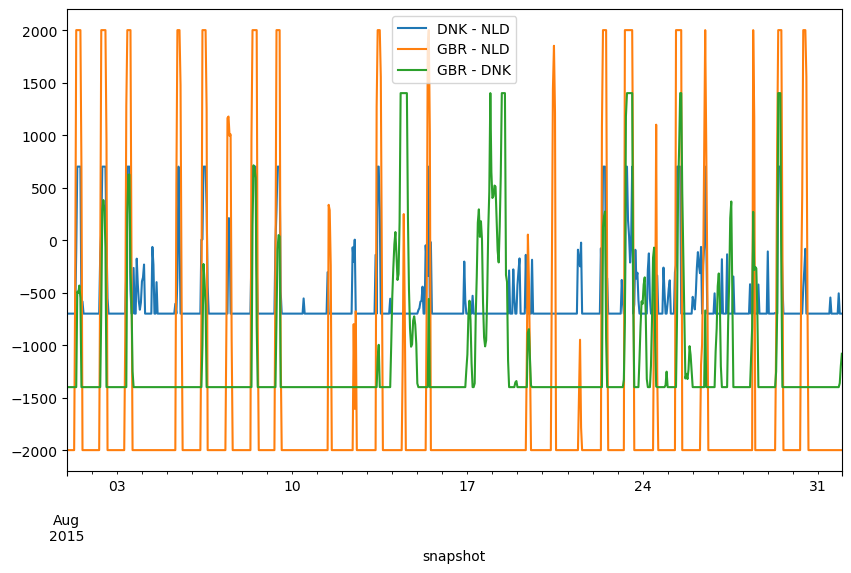

In [2541]:
plt.figure(figsize=(10, 6))
n.links_t.p1.loc["2015-08"]["DNK - NLD"].plot(label="DNK - NLD")
n.links_t.p1.loc["2015-08"]["GBR - NLD"].plot(label ="GBR - NLD")
n.links_t.p1.loc["2015-08"]["GBR - DNK"].plot(label = "GBR - DNK")
plt.legend()


In [2542]:
n.links.p_nom_opt

Link
CHP GBR          60638.886275
CHP DNK          14322.521331
CHP NLD          30855.538207
heat pump GBR    21553.428342
heat pump DNK     2409.543914
heat pump NLD     7134.597036
GBR - DNK         1400.000000
GBR - NLD         2000.000000
DNK - NLD          700.000000
Name: p_nom_opt, dtype: float64

In [2543]:
"Utilisation of Transmission Lines";
n.links_t.p0.abs().mean()/n.links.p_nom_opt

Link
CHP GBR          0.018825
CHP DNK          0.079703
CHP NLD          0.036997
heat pump GBR    0.540107
heat pump DNK    0.650180
heat pump NLD    0.527561
GBR - DNK        0.898421
GBR - NLD        0.965909
DNK - NLD        0.925675
dtype: float64

In [2544]:
"Congestion Rent";

# MEUR
((n.buses_t.marginal_price["electrical bus GBR"] - n.buses_t.marginal_price["electrical bus DNK"])*n.links_t.p0["GBR - DNK"]).sum()/1e6


-117.32065586448373

In [2545]:
# MEUR
((n.buses_t.marginal_price["electrical bus GBR"] - n.buses_t.marginal_price["electrical bus NLD"])*n.links_t.p0["GBR - NLD"]).sum()/1e6


-46.773383228218556

In [2546]:
# MEUR
((n.buses_t.marginal_price["electrical bus DNK"] - n.buses_t.marginal_price["electrical bus NLD"])*n.links_t.p0["DNK - NLD"]).sum()/1e6


-66.86223418938171

In [2547]:
n

PyPSA Network
Components:
 - Bus: 9
 - Carrier: 7
 - Generator: 15
 - GlobalConstraint: 1
 - Link: 9
 - Load: 6
 - Store: 3
 - SubNetwork: 9
Snapshots: 8760

In [2548]:
n.generators_t.p

Generator,GBR onshorewind,DNK onshorewind,NLD onshorewind,GBR offshorewind,DNK offshorewind,NLD offshorewind,GBR CCGT,DNK CCGT,NLD CCGT,GBR solar,DNK solar,NLD solar,GBR nuclear,DNK nuclear,NLD nuclear
snapshot,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,8484.0,1748.0,2508.840,9616.0,1809.0,3482.096,20503.967290,996.519152,8741.535570,0.0,0.0,0.0,8603.513403,0.0,0.0
2015-01-01 01:00:00+00:00,8540.0,1767.0,2669.127,9104.0,1919.7,3595.952,20868.053228,686.780873,8076.678618,0.0,0.0,0.0,8603.513403,0.0,0.0
2015-01-01 02:00:00+00:00,8288.0,1816.4,2906.073,8608.0,2057.4,3733.528,18958.871661,0.000000,7280.725026,0.0,0.0,0.0,8603.513403,0.0,0.0
2015-01-01 03:00:00+00:00,7980.0,2082.4,3010.608,8624.0,2173.5,3766.736,16889.070862,0.000000,5988.439979,0.0,0.0,0.0,8603.513403,0.0,0.0
2015-01-01 04:00:00+00:00,7728.0,2253.4,3087.267,8976.0,2268.0,3804.688,14836.213510,0.000000,5282.092716,0.0,0.0,0.0,8603.513403,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 19:00:00+00:00,7112.0,661.2,3122.112,11760.0,1177.2,3785.712,28420.061559,3094.719745,9115.190861,0.0,0.0,0.0,8603.513403,0.0,0.0
2015-12-31 20:00:00+00:00,5964.0,551.0,3240.585,10656.0,950.4,3785.712,28622.274280,3410.627694,8395.991849,0.0,0.0,0.0,8603.513403,0.0,0.0
2015-12-31 21:00:00+00:00,4704.0,535.8,3143.019,8864.0,869.4,3766.736,29894.740205,3479.295127,8095.228192,0.0,0.0,0.0,8603.513403,0.0,0.0


In [2549]:
-n.links_t.p1.loc["2015-01"]["CHP GBR"].sum() # MWh
-n.links_t.p1.loc["2015-01"]["CHP DNK"].sum() # MWh
-n.links_t.p1.loc["2015-01"]["CHP NLD"].sum() # MWh

1771650.1334019245

In [2550]:
gen.unstack(level='carrier').fillna(0)["gas"]
gen.unstack(level='carrier').fillna(0)["nuclear"]
gen.unstack(level='carrier').fillna(0)["offshorewind"]
gen.unstack(level='carrier').fillna(0)["onshorewind"]
gen.unstack(level='carrier').fillna(0)["solar"]


bus
electrical bus DNK    3.765614e+06
electrical bus GBR    1.555518e+07
electrical bus NLD    2.338321e+07
Name: solar, dtype: float64

In [2551]:
gen.unstack(level='carrier').fillna(0)["gas"]["electrical bus DNK"]
gen.unstack(level='carrier').fillna(0)["nuclear"]["electrical bus DNK"]
gen.unstack(level='carrier').fillna(0)["nuclear"]["electrical bus DNK"]
gen.unstack(level='carrier').fillna(0)["offshorewind"]["electrical bus DNK"]
gen.unstack(level='carrier').fillna(0)["onshorewind"]["electrical bus DNK"]
gen.unstack(level='carrier').fillna(0)["solar"]["electrical bus DNK"]

3765614.4445278794

In [2552]:
CHP_el_GBR.sum()
CHP_el_DNK.sum()
CHP_el_NLD.sum()

1772195.427751382

In [2553]:
gen.unstack(level='carrier').fillna(0)


carrier,gas,nuclear,offshorewind,onshorewind,solar
bus,,,,,
electrical bus DNK,1.360390e+07,0.000000e+00,1.077383e+07,9.743789e+06,3.765614e+06
electrical bus GBR,2.337172e+08,7.526870e+07,4.878125e+07,3.189537e+07,1.555518e+07
electrical bus NLD,6.846834e+07,0.000000e+00,1.535536e+07,1.461958e+07,2.338321e+07


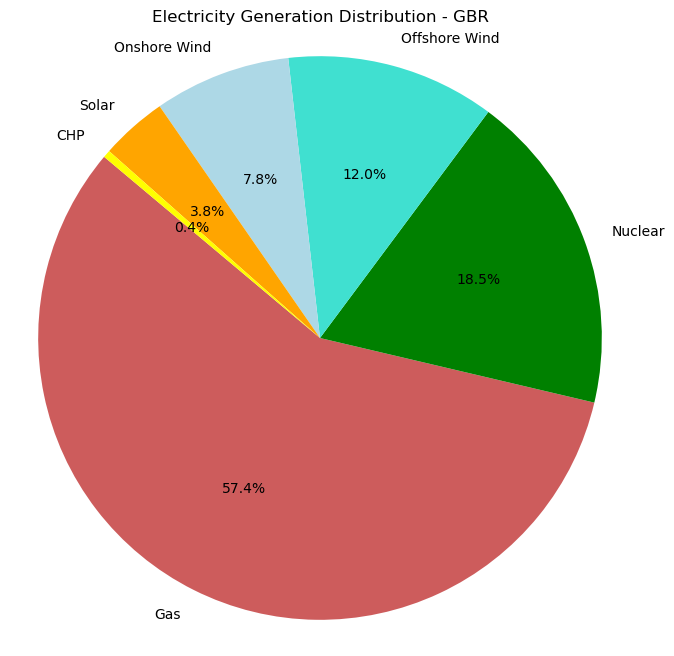

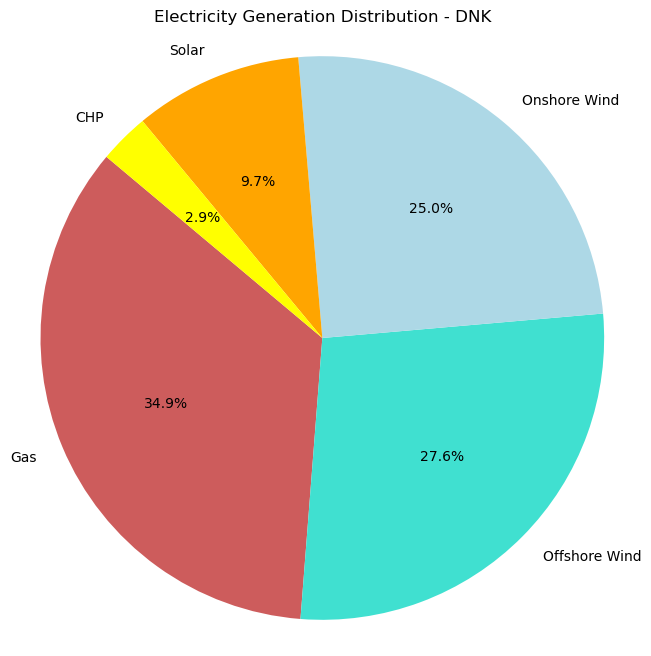

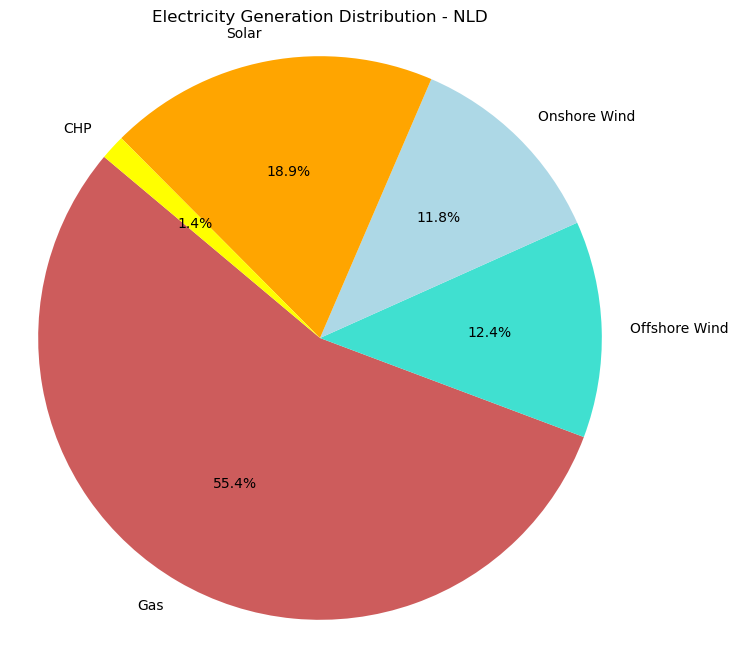

In [2554]:
import matplotlib.pyplot as plt

# Define custom colors
custom_colors = {
    "Gas": "indianred",
    "Nuclear": "green",
    "Offshore Wind": "turquoise",
    "Onshore Wind": "lightblue",
    "Solar": "orange",
    "CHP": "yellow",
}

# Helper function
def plot_pie_chart(country, CHP_series):
    bus = f"electrical bus {country}"
    data = gen.unstack(level='carrier').fillna(0)

    gas = data.loc[bus, "gas"]
    nuclear = data.loc[bus, "nuclear"]
    offshorewind = data.loc[bus, "offshorewind"]
    onshorewind = data.loc[bus, "onshorewind"]
    solar = data.loc[bus, "solar"]
    chp = CHP_series.sum()

    labels = ["Gas", "Nuclear", "Offshore Wind", "Onshore Wind", "Solar", "CHP"]
    values = [gas, nuclear, offshorewind, onshorewind, solar, chp]

    # Filter out zero (or negative) values
    filtered = [(label, value) for label, value in zip(labels, values) if value > 0]
    if not filtered:
        print(f"No non-zero generation for {country}. Pie chart not generated.")
        return

    filtered_labels, filtered_values = zip(*filtered)
    filtered_colors = [custom_colors[label] for label in filtered_labels]

    plt.figure(figsize=(8, 8))
    plt.pie(filtered_values, labels=filtered_labels, colors=filtered_colors, autopct='%1.1f%%', startangle=140)
    plt.title(f"Electricity Generation Distribution - {country}")
    plt.axis('equal')
    plt.show()

# Example usage
plot_pie_chart("GBR", CHP_el_GBR)
plot_pie_chart("DNK", CHP_el_DNK)
plot_pie_chart("NLD", CHP_el_NLD)



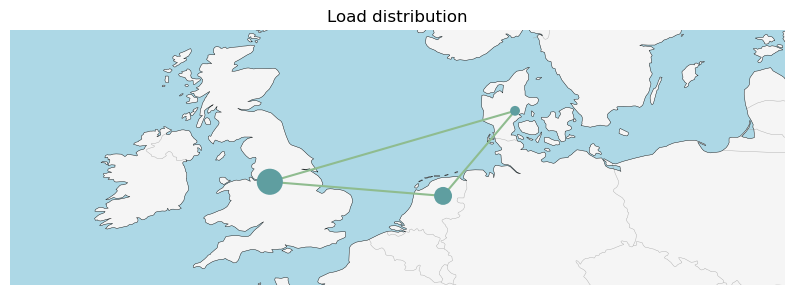

In [2555]:
fig, ax = plt.subplots(
    1, 1, subplot_kw={"projection": ccrs.EqualEarth()},figsize=(10, 10)
)

load_distribution = (
    n.loads_t.p_set.loc[n.snapshots[0]].groupby(n.loads.bus).sum()
)
n.plot(bus_sizes=0.5e-5 * load_distribution,margin= 1,color_geomap=True,ax=ax, title="Load distribution");

<Axes: xlabel='snapshot'>

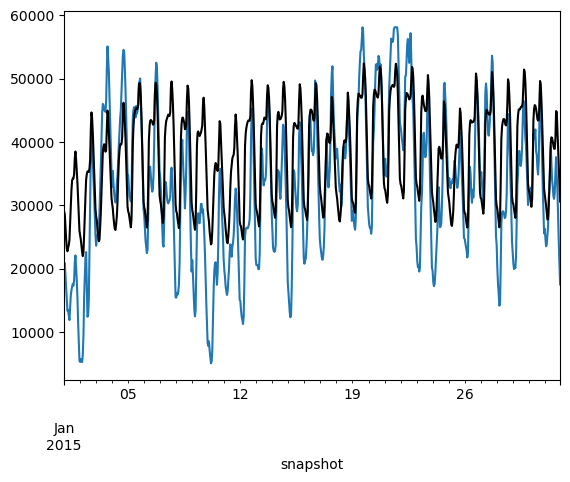

In [2556]:
#n.generators_t.p["GBR offshorewind"].loc["2015-01"].plot(label="GBR offshorewind") 
#n.generators_t.p["GBR onshorewind"].loc["2015-01"].plot(label="GBR onshorewind")
#n.generators_t.p["GBR solar"].loc["2015-01"].plot(label="GBR solar")
#n.generators_t.p["GBR nuclear"].loc["2015-01"].plot(label="GBR nuclear")
n.generators_t.p["GBR CCGT"].loc["2015-01"].plot(label="GBR CCGT")
n.loads_t.p_set["electric load GBR"].loc["2015-01"].plot(label="GBR", color = "black")

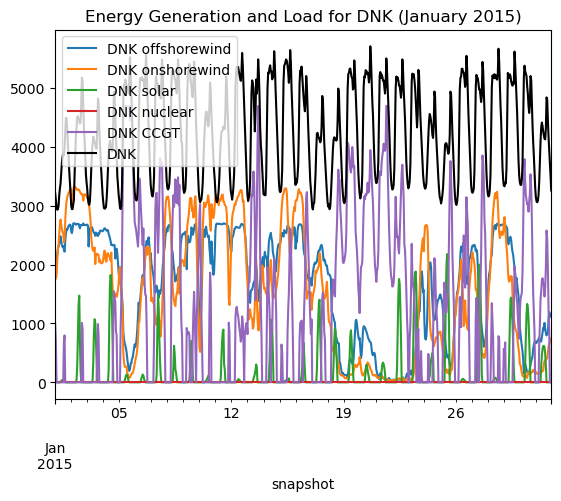

In [2557]:
# Plot for DNK
n.generators_t.p["DNK offshorewind"].loc["2015-01"].plot(label="DNK offshorewind")
n.generators_t.p["DNK onshorewind"].loc["2015-01"].plot(label="DNK onshorewind")
n.generators_t.p["DNK solar"].loc["2015-01"].plot(label="DNK solar")
n.generators_t.p["DNK nuclear"].loc["2015-01"].plot(label="DNK nuclear")
n.generators_t.p["DNK CCGT"].loc["2015-01"].plot(label="DNK CCGT")
n.loads_t.p_set["electric load DNK"].loc["2015-01"].plot(label="DNK", color="black")

plt.legend()
plt.title("Energy Generation and Load for DNK (January 2015)")
plt.show()


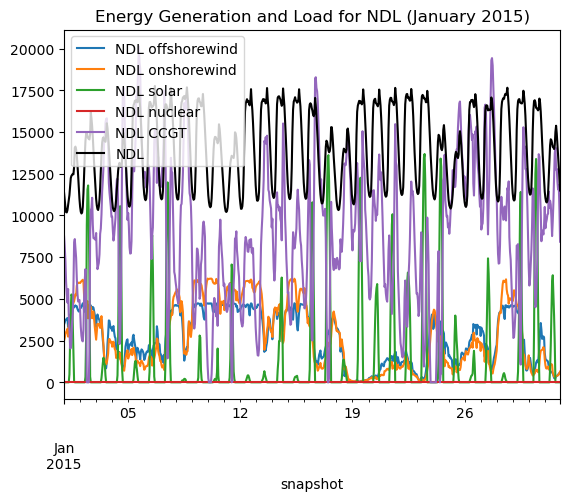

In [2558]:
# Plot for NDL
n.generators_t.p["NLD offshorewind"].loc["2015-01"].plot(label="NDL offshorewind")
n.generators_t.p["NLD onshorewind"].loc["2015-01"].plot(label="NDL onshorewind")
n.generators_t.p["NLD solar"].loc["2015-01"].plot(label="NDL solar")
n.generators_t.p["NLD nuclear"].loc["2015-01"].plot(label="NDL nuclear")
n.generators_t.p["NLD CCGT"].loc["2015-01"].plot(label="NDL CCGT")
n.loads_t.p_set["electric load NLD"].loc["2015-01"].plot(label="NDL", color="black")

plt.legend()
plt.title("Energy Generation and Load for NDL (January 2015)")
plt.show()

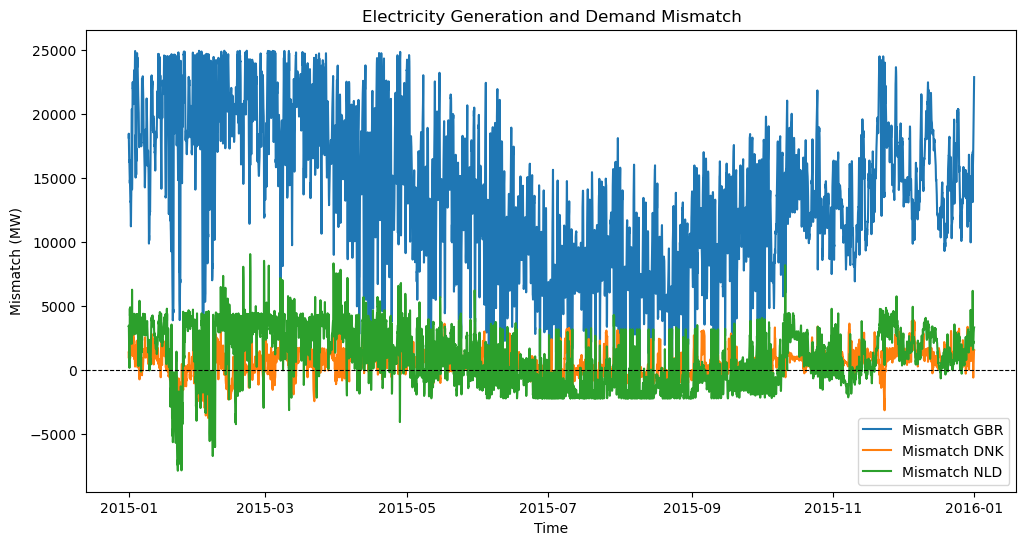

In [2559]:
# Calculate mismatch for each country
mismatch_GBR = n.generators_t.p.filter(like="GBR").sum(axis=1) - n.loads_t.p_set["electric load GBR"]
mismatch_DNK = n.generators_t.p.filter(like="DNK").sum(axis=1) - n.loads_t.p_set["electric load DNK"]
mismatch_NLD = n.generators_t.p.filter(like="NLD").sum(axis=1) - n.loads_t.p_set["electric load NLD"]

# Plot the mismatch
plt.figure(figsize=(12, 6))
plt.plot(mismatch_GBR, label="Mismatch GBR")
plt.plot(mismatch_DNK, label="Mismatch DNK")
plt.plot(mismatch_NLD, label="Mismatch NLD")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)  # Reference line for zero mismatch
plt.title("Electricity Generation and Demand Mismatch")
plt.xlabel("Time")
plt.ylabel("Mismatch (MW)")
plt.legend()
plt.show()

<Axes: xlabel='snapshot'>

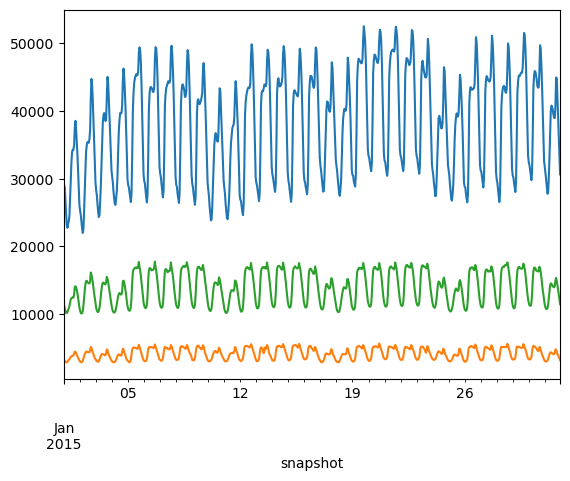

In [2561]:
n.loads_t.p_set["electric load GBR"].loc["2015-01"].plot(label="GBR")
n.loads_t.p_set["electric load DNK"].loc["2015-01"].plot(label="DNK")
n.loads_t.p_set["electric load NLD"].loc["2015-01"].plot(label="NLD")   